# Fitting a spectrum model  using Gradient Descent in JAXopt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

Here, we use the mock spectrum generated by the tutorial of "Foward modeling". 

In [2]:
dat=pd.read_csv("spectrum.txt",delimiter=",",names=("wav","flux"))

We add Gaussian noise to data. nusd is the observing wavenumber grid. 

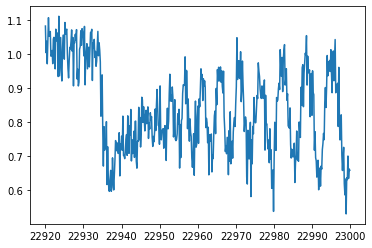

In [3]:
wavd=dat["wav"].values
flux=dat["flux"].values
nusd=jnp.array(1.e8/wavd[::-1])
sigmain=0.05
norm=40000
nflux=flux/norm+np.random.normal(0,sigmain,len(wavd))
plt.plot(wavd[::-1],nflux)


In [4]:
from exojax.spec.lpf import xsmatrix
from exojax.spec.exomol import gamma_exomol
from exojax.spec.hitran import SijT, doppler_sigma, gamma_natural, gamma_hitran
from exojax.spec.hitrancia import read_cia, logacia
from exojax.spec.rtransfer import rtrun, dtauM, dtauCIA, nugrid
from exojax.spec import planck, response
from exojax.spec.lpf import xsvector
from exojax.spec import molinfo
from exojax.utils.constants import RJ, pc, Rs, c

The model is almost same as the forward modeling, but we will infer here Rp, RV, MMR_CO, T0, alpha, and Vsini. 

In [5]:
from exojax.spec import rtransfer as rt
NP=100
Parr, dParr, k=rt.pressure_layer(NP=NP)
Nx=1500
nus,wav,res=nugrid(np.min(wavd)-5.0,np.max(wavd)+5.0,Nx,unit="AA")

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R)

molmassCO=molinfo.molmass("CO")
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR

Mp = 33.2 #fixing mass...

xsmode assumes ESLOG: mode= lpf


Loading the molecular database of CO and the CIA

In [6]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus,crit=1.e-46)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
H2-H2


We have only 39 CO lines. 

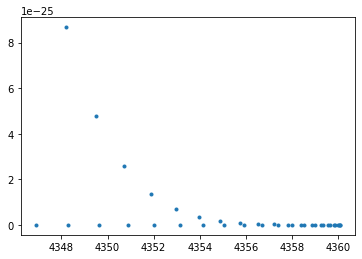

In [7]:
plt.plot(mdbCO.nu_lines,mdbCO.Sij0,".")

Again, numatrix should be precomputed prior to HMC-NUTS.

In [8]:
from exojax.spec import make_numatrix0
numatrix_CO=make_numatrix0(nus,mdbCO.nu_lines)

In [9]:
#Or you can use initspec.init_lpf instead.
from exojax.spec import initspec
numatrix_CO=initspec.init_lpf(mdbCO.nu_lines,nus)

In [10]:
#reference pressure for a T-P model                                             
Pref=1.0 #bar
ONEARR=np.ones_like(Parr)
ONEWAV=jnp.ones_like(nflux)

In [11]:
import jax.numpy as jnp
from jax import vmap, jit

Now we write the model, which is used in HMC-NUTS.

In [12]:
def model_c(params,boost,nu1):
    Rp,RV,MMR_CO,T0,alpha,vsini=params*boost
    g=2478.57730044555*Mp/Rp**2 #gravity                                        
    u1=0.0
    u2=0.0
    #T-P model//                                                                
    Tarr = T0*(Parr/Pref)**alpha

    #line computation CO                                                        
    qt_CO=vmap(mdbCO.qr_interp)(Tarr)

    def obyo(nusd,nus,numatrix_CO,mdbCO,cdbH2H2):
        #CO                                                                     
        SijM_CO=jit(vmap(SijT,(0,None,None,None,0)))\
            (Tarr,mdbCO.logsij0,mdbCO.dev_nu_lines,mdbCO.elower,qt_CO)
        gammaLMP_CO = jit(vmap(gamma_exomol,(0,0,None,None)))\
            (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
        gammaLMN_CO=gamma_natural(mdbCO.A)
        gammaLM_CO=gammaLMP_CO+gammaLMN_CO[None,:]
        
        sigmaDM_CO=jit(vmap(doppler_sigma,(None,0,None)))\
            (mdbCO.dev_nu_lines,Tarr,molmassCO)
        xsm_CO=xsmatrix(numatrix_CO,sigmaDM_CO,gammaLM_CO,SijM_CO)
        dtaumCO=dtauM(dParr,xsm_CO,MMR_CO*ONEARR,molmassCO,g)
        #CIA                                                                    
        dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
                          mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)
        dtau=dtaumCO+dtaucH2H2
        sourcef = planck.piBarr(Tarr,nus)
        F0=rtrun(dtau,sourcef)/norm
        
        Frot=response.rigidrot(nus,F0,vsini,u1,u2)
        #Frot=rigidrotx(nus,F0,vsini,u1,u2)
        mu=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)
        return mu
    
    model=obyo(nu1,nus,numatrix_CO,mdbCO,cdbH2H2)
    return model

Here, we use JAXopt as an optimizer. JAXopt is not automatically installed. If you need install it by pip:

pip install jaxopt

In [13]:
import jaxopt

We use a GradientDescent as an optimizer. Let's normalize the parameters. 

In [14]:
#Rp,RV,MMR_CO,T0,alpha,vsini
boost=np.array([1.0,10.0,0.1,1000.0,1.e-3,10.0])
initpar=np.array([0.8,9.0,0.1,1200.0,0.1,17.0])/boost

Define the objective function by a L2 norm.

In [15]:
def objective(params):
    f=nflux-model_c(params,boost,nusd)
    g=jnp.dot(f,f)
    return g

Then, run the gradient descent. 

In [16]:
gd = jaxopt.GradientDescent(fun=objective, maxiter=1000,stepsize=1.e-4)
res = gd.run(init_params=initpar)
params, state = res

The best-fit parameters

In [17]:
params*boost

DeviceArray([7.4454439e-01, 1.0113935e+01, 6.6364571e-03, 1.2761028e+03,
             9.9855691e-02, 2.0668566e+01], dtype=float32)

Plot the results. It works well!

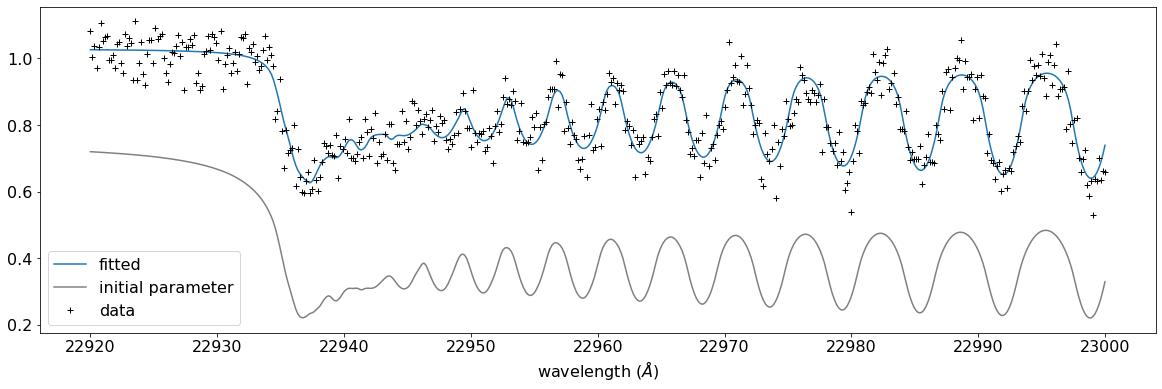

In [18]:
model=model_c(params,boost,nusd)
inmodel=model_c(initpar,boost,nusd)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],model,color="C0",label="fitted")
ax.plot(wavd[::-1],inmodel,color="gray",label="initial parameter")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("gradient_descent_jaxopt.png")

In [19]:
from jaxopt import OptaxSolver
import optax

In [35]:
solver = OptaxSolver(opt=optax.adam(1e-4), fun=objective, has_aux=True)

In [36]:
state = solver.init_state(initpar)

In [37]:
params=np.copy(initpar)
param, state = solver.update(params=params, state=state)
#for _ in range(50):
#    param, state = solver.update(params=params, state=state)
    # The auxiliary data returned by the outer loss is stored in the state.                                             
    # = state.aux


2022-03-14 16:37:57.961574: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.58MiB (rounded to 9000192)requested by op 
2022-03-14 16:37:57.963944: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] *************************************************************************************************xxx
2022-03-14 16:37:57.964135: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2124] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    11.7KiB
              constant allocation:         0B
        maybe_live_out allocation:    8.58MiB
     preallocated temp allocation:         0B
                 total allocation:    8.59MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	B

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 9000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    11.7KiB
              constant allocation:         0B
        maybe_live_out allocation:    8.58MiB
     preallocated temp allocation:         0B
                 total allocation:    8.59MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 8.58MiB
		Operator: op_name="jit(<lambda>)/jit(main)/sub" source_file="/home/kawahara/anaconda3/lib/python3.8/site-packages/exojax-1.1.2-py3.8.egg/exojax/spec/response.py" source_line=64
		XLA Label: fusion
		Shape: f32[1500,1500]
		==========================

	Buffer 2:
		Size: 5.9KiB
		Entry Parameter Subshape: f32[1,1500]
		==========================

	Buffer 3:
		Size: 5.9KiB
		Entry Parameter Subshape: f32[1500,1]
		==========================

